In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from random import choices
from scipy import stats
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,f1_score,roc_curve
import datetime
import math
from collections import Counter
from PyALE import ale
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

# Classification

In [ ]:
def scale_features(x_train, x_test):
    scaler = StandardScaler()
    x_train_raw = x_train.copy()
    x_test_raw = x_test.copy()
    scaler.fit(x_train)
    x_train_norm = pd.DataFrame(data = scaler.transform(x_train_raw), columns = list(x_train_raw.columns))
    x_test_norm = pd.DataFrame(data = scaler.transform(x_test_raw), columns = list(x_train_raw.columns))
    return x_train_norm, x_test_norm, x_train_raw, x_test_raw

In [ ]:
def cm_metrics(cmiter):
    # FP = cmiter.sum(axis=0) - np.diag(cmiter)
    # FN = cmiter.sum(axis=1) - np.diag(cmiter)
    # TP = np.diag(cmiter)
    # TN = confusion_matrix.sum() - (FP + FN + TP)

    TN, FP, FN, TP = cmiter.ravel()
    test_sensitivity = TP/(TP+FN)
    test_specificity = TN/(TN+FP)
    test_PPV = TP/(TP+FP)
    test_NPV = TN/(TN+FN)
    return test_sensitivity, test_specificity, test_PPV, test_NPV

def general_metrics(y_true, y_pred):
    test_acc = accuracy_score(y_true, y_pred)
    test_roc = roc_auc_score(y_true, y_pred)
    test_f1 = f1_score(y_true, y_pred,average='weighted')
    return test_acc, test_roc, test_f1

In [ ]:
datatrain = pd.read_excel('drive/MyDrive/Dissertation/data/train_data_fixedltcs.xlsx')
datatest = pd.read_excel('drive/MyDrive/Dissertation/data/test_data_fixedltcs.xlsx')
datatest = datatest[datatrain.columns]

In [ ]:
toremove = ['eid', 'first_admi_date','first_discharge_date', 'second_admi_date', 'delta_length', 'admi_meth']
datatrain.drop(toremove, axis = 1, inplace = True)
datatest.drop(toremove, axis = 1, inplace = True)

In [ ]:
admission = list(datatrain.columns)[0]
target = list(datatrain.columns)[1]
demographics = list(datatrain.columns)[2:12]
hist_drugs =  list(datatrain.columns)[12:508]
pread_drugs = list(datatrain.columns)[508:846]
ltcs = list(datatrain.columns)[846:1047]
diags = list(datatrain.columns)[1047:]

print(admission)
print(target)
print(demographics[0],demographics[-1])
print(hist_drugs[0],hist_drugs[-1])
print(pread_drugs[0],pread_drugs[-1])
print(ltcs[0],ltcs[-1])
print(diags[0],diags[-1])

binary = ['sex'] + hist_drugs + pread_drugs + ltcs + diags
target = target
continuous = ['age_at_event','first_admi_duration','ltc_count', 'townsend_deprivation_index','alcohol_intake_frequency', 'smoking_status',
              'relative_smoking_pack_years', 'ethnic_background','BMI', 'body_fat_percentage']

In [ ]:
selection2prop = pd.read_excel('drive/MyDrive/Dissertation/data/selection2prop005_imbalanced data.xlsx')
selected = selection2prop.selected.values

In [ ]:
x_train = datatrain.drop('readmission_state', axis = 1)
y_train = datatrain['readmission_state']
x_test = datatest.drop('readmission_state', axis = 1)
y_test = datatest['readmission_state']


# Scale data set

In [ ]:
x_train_norm, x_test_norm, x_train_raw, x_test_raw = scale_features(x_train, x_test)

## XGBOOST HYPERPARAMETER TUNING

In [ ]:
# Generate DMatrix to train XGBoost model, remove [selected] if you want to train the model with the whole set of features
dtrain = xgb.DMatrix(x_train[selected], label=y_train)
dtest = xgb.DMatrix(x_test[selected], label=y_test)

# Define Hyperparameter search space
counter = Counter(y_train)
estimate = counter[0] / counter[1]
gridsearch_params = [(n_estimators, max_depth, learning_rate, gamma, colsample_bytree, scale_pos_weight)
                    for n_estimators in [50,100,150,200]
                    for max_depth in [20,25,30,35,45,50]
                    for learning_rate in [0.2,0.3,0.4,0.5]
                    for gamma in [0.1,0.3,0.5]
                    for colsample_bytree in [0.7,0.85,1]
                    for scale_pos_weight in [estimate]]

# Since we are optimizing on AUC, define baseline value as 0, any hyperparameter configuration getting better AUC will be saved
max_auc = float(0)
best_params = None

# Iterate over all hyperparameter configurations defined earlier
for n_estimators,max_depth,learning_rate,gamma,colsample_bytree,scale_pos_weight in gridsearch_params:
    # Update parameters
    params = dict()
    params['max_depth'] = max_depth
    params['learning_rate'] = learning_rate
    params['gamma'] = gamma
    params['colsample_bytree'] = colsample_bytree
    params['scale_pos_weight'] = scale_pos_weight

    # Run 5-fold CV, inlcuding early stopping
    cv_results = xgb.cv(params,dtrain,num_boost_round=n_estimators, seed=42,nfold=5,metrics={'auc'},early_stopping_rounds=10)

    # Update best auc
    max_auc_cv = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()

    # If the results in this iteration are the best yet, update the hyperparameter configuration and the AUC value obtained.
    if max_auc_cv > max_auc:
        max_auc = max_auc_cv
        best_params = [n_estimators,max_depth,learning_rate,gamma,colsample_bytree,scale_pos_weight]

print("Best params: {},{}, AUC: {}".format(best_params,n_estimators, max_auc))

In [ ]:
# Evaluate model with the selected hyperparameter configuration
model = xgb.XGBClassifier(booster = 'gbtree', n_estimators = best_params[0], max_depth = best_params[1], colsample_bytree=best_params[4], gamma=best_params[3], learning_rate= best_params[2], scale_pos_weight = estimate, random_state=4242, n_jobs = -1)
model.fit(x_train[selected], y_train)

# Save model for later
modelname = classifier + job
with open('models/{}.pkl'.format(modelname),'wb') as f:
    pickle.dump(model,f)

best_parameters = {'booster':'gbtree', 'n_estimators':150,'colsample_bytree':0.7, 'gamma':0.5,
                   'learning_rate':0.2, 'scale_pos_weight':3.201933972954597, 'random_state':4242, 'n_jobs':-1}


y_pred = model.predict(x_test[selected])

test_acc, test_roc, test_f1 = general_metrics(y_test, y_pred)
cmiter = confusion_matrix(y_test,y_pred)
test_sensitivity, test_specificity, test_PPV, test_NPV = cm_metrics(cmiter)

y_pred_proba = model.predict_proba(x_test[selected])[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

metrics_dict = {'accuracy_test':test_acc, 'roc_test': test_roc, 'f1': test_f1,
            'PPV_test':test_PPV, 'NPV_test':test_NPV ,'sensitivity':test_sensitivity, 'specificity': test_specificity,
            'cm': np.asarray(cmiter)}

print(metrics_dict)

# training ROC
y_pred_proba_train = model.predict_proba(x_train[selected])[::,1]
fpr_train, tpr_train, _ = roc_curve(y_train,  y_pred_proba_train)
auc_train = roc_auc_score(y_train, y_pred_proba_train)
plt.plot(fpr_train,tpr_train,'b',label="Training AUC="+str(auc_train))
# test ROC
y_pred_proba = model.predict_proba(x_test[selected])[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,'g',label="Test AUC="+str(auc))
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=4)
plt.savefig('figures/roc/{}_{}_roc.pdf'.format('first_retrain_featureselection', 'xgb'), bbox_inches = 'tight')

metrics_dict = {'Date':datetime.datetime.now(), 'job': 'first_retrain_featureselection', 'Classifier':'xgb','Best_params':best_parameters,
                'Training_score': None,'accuracy_test':test_acc, 'roc_test': test_roc, 'f1': test_f1,
                'PPV_test':test_PPV, 'NPV_test':test_NPV ,'sensitivity':test_sensitivity, 'specificity': test_specificity,
                'cm': np.asarray(cmiter),'incorrect_indices': []}

df_metrics = pd.read_excel("metrics/metrics.xlsx")
df_metrics = df_metrics.append(metrics_dict, ignore_index=True)
df_metrics.to_excel("metrics/metrics.xlsx", index=False)

# SHAP

In [ ]:
with open("drive/MyDrive/Dissertation/models/xgbfirst_retrain_allfeatures.pkl", "rb") as f:
    model = pickle.load(f)

In [ ]:
classifier='xgb'
job='first_retrain_allfeatures'
deita = shap.sample(x_test, 1000)
explainer = shap.KernelExplainer(model.predict, deita)
shap_values = explainer.shap_values(deita)
shap_expected = explainer.expected_value

finalfeats = ['Age at Event', 'LTC count', 'First Admission Duration','No Historical Prescriptions', 
             'Historical Proton Pump Inhibitors','Historical Opioid Analgesics','Historical Lipid-Regulating Drugs',
             'Townsend Deprivation Index', 'Historical Non-Opioid Analgesics And \n Compound Prep',
             'No Preadmission Prescriptions', 'Body Fat (%)', 'Alcohol Intake Frequency', 'Historical Antiplatelet drugs',
             'BMI', 'Osmotic Laxatives', 'Oral Anticoagulant Preps', 'Smoking Pack Years','Historical Prophylaxis Of Migraine',
             'Historical Oestrogens And Hrt', 'Historical NSAIDs']

shap.summary_plot(shap_values, deita, max_display = 20, color=plt.get_cmap("cool"), show=False)
plt.xlabel("SHAP values")
plt.yticks(range(0, 20),finalfeats[::-1])
plt.savefig('figures/shap/{}_{}_shap_summary.pdf'.format(classifier, job), bbox_inches = 'tight')
plt.clf()
plt.close()

shap.summary_plot(shap_values,deita, plot_type="bar",  max_display = 20, show=False)
plt.xlabel("Mean SHAP value")
plt.yticks(range(0, 20),['']*20)
plt.savefig('figures/shap/{}_{}_shap_bar.pdf'.format(classifier, job), bbox_inches = 'tight')
plt.clf()
plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

# ALE

In [ ]:
def plot_corresponding_ale_numerical_feature(df_ale_numerical, df_ale_numerical_raw, var_name,idx,listvars, estimator_name, job, flag_save_figure=True):

    var_name_real = listvars[idx]
    df_ale_numerical = df_ale_numerical.reset_index()
    df_ale_numerical_raw = df_ale_numerical_raw.reset_index()
    first_std = df_ale_numerical.iloc[0, 1]
    df_ale_numerical['lowerCI_95%'] = df_ale_numerical['lowerCI_95%'].fillna(first_std)
    df_ale_numerical['upperCI_95%'] = df_ale_numerical['upperCI_95%'].fillna(first_std)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.1))
    ax.plot(df_ale_numerical_raw[var_name], df_ale_numerical['eff'], ls='solid', color='blue')
    ax.fill_between(df_ale_numerical_raw[var_name], df_ale_numerical['lowerCI_95%'], df_ale_numerical['upperCI_95%'], label='95% CI', alpha=0.3, color='grey', lw=2)
    ax.set_xlabel(var_name_real, fontsize=12)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.legend()
    plt.grid(alpha=0.5, linestyle='--')
    fig.tight_layout()

    if '<' in var_name:
        var_name = var_name.replace("<", "")

    plt.savefig('figures/ale/{}_{}_ale_{}_seed.pdf'.format(job,estimator_name,var_name), bbox_inches = 'tight')
    plt.clf()
    plt.close()

def plot_corresponding_ale_categorical_feature(df_ale_cat, var_name,idx,listvars, estimator_name, job, flag_save_figure=True):

    var_name_real = listvars[idx]
    df_ale_cat = df_ale_cat.reset_index()
    first_std = df_ale_cat.iloc[0, 1]
    df_ale_cat['lowerCI_95%'] = df_ale_cat['lowerCI_95%'].fillna(first_std)
    df_ale_cat['upperCI_95%'] = df_ale_cat['upperCI_95%'].fillna(first_std)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.1))
    ax.bar(df_ale_cat[var_name], df_ale_cat['eff'], width=0.4, color='blue', alpha=0.0)
    ax.set_ylabel('', fontsize=16)
    ax2 = ax.twinx()
    ax2.bar(df_ale_cat[var_name], df_ale_cat['size'], width=0.4, color='blue', alpha=0.3)
    ax2.set_ylabel('Size', fontsize=16)
    ax.plot([df_ale_cat.iloc[0, 0], df_ale_cat.iloc[1, 0]],[df_ale_cat.iloc[0, 1], df_ale_cat.iloc[1, 1]],'--', marker='o', color='black')

    for index, row in df_ale_cat.iterrows():
        p_inf = [row[var_name], row['lowerCI_95%']]
        p_center = [row[var_name], row['eff']]
        yerr = math.sqrt((p_center[0] - p_inf[0])**2 + (p_center[1] - p_inf[1])**2)
        ax.errorbar(row[var_name], row['eff'], yerr, fmt='o', lw=2, capsize=4, color='black')

    ax.set_xlabel(var_name_real, fontsize=12)
    ax.set_xticks([0, 1])
    plt.grid(alpha=0.5, linestyle='--')
    fig.tight_layout()

    if '<' in var_name:
        var_name = var_name.replace("<", "")

    plt.savefig('figures/ale/{}_{}_ale_{}_seed.pdf'.format(job,estimator_name,var_name), bbox_inches = 'tight')
    plt.clf()
    plt.close()

def plot_ale_features(df_x_test, model_estimator, df_x_test_raw, list_vars_numerical, list_vars_categorical,listvarsnumerical,listvarscategorical, estimator_name, job):

    for idx,var_numerical in enumerate(list_vars_numerical):
        df_ale_numerical = ale(X=df_x_test,model=model_estimator,feature=[var_numerical],plot=False,feature_type="continuous",grid_size=10,include_CI=True,C=0.95)
        df_ale_numerical_raw = ale(X=df_x_test_raw,model=model_estimator,feature=[var_numerical],plot=False,feature_type="continuous",grid_size=10,include_CI=True,C=0.95)
        plot_corresponding_ale_numerical_feature(df_ale_numerical, df_ale_numerical_raw, var_numerical,idx,listvarsnumerical,estimator_name, job)

    for idx,var_categorical in enumerate(list_vars_categorical):
        ale_discr = ale(X=df_x_test,model=model_estimator,feature=[var_categorical],feature_type="discrete",plot=False,grid_size=10,include_CI=True,C=0.95)
        plot_corresponding_ale_categorical_feature(ale_discr, var_categorical,idx,listvarscategorical,estimator_name, job)

In [ ]:
bina = ['hist_none', 'hist_0103050','hist_0407020','hist_0212000',
        'hist_0407010','pread_none', 'alcohol_intake_frequency',
        'hist_0209000','smoking_status','hist_0901011','hist_0906040',
        'hist_0206010','hist_0603020','sex','hist_0501012',
        'diag_C509','hist_0403030','hist_0202010','hist_0408010',
        'hist_0604011','hist_1001010','hist_0407010','relative_smoking_pack_years']
binagood = ['No Historical \n Prescriptions', 'Historical \n Proton Pump Inhibitors','Historical \n Opioid Analgesics', 'Historical \n Lipid-Regulating Drugs',
            'Historical \n Non-Opioid Analgesics And Compound Prep', 'No Preadmission Prescriptions','Alcohol Intake Frequency',
            'Historical \n Antiplatelet drugs', 'Smoking Status','Historical \n Oral Iron', 'Historical Vitamin D',
            'Historical Nitrates','Historical Corticosteroids', 'Gender', 'Historical Penicillinase-Resistant \n Penicillins',
            'Malignant neoplasm of \n breast of unspecified site','Historical Selective Serotonin \n Re-Uptake Inhibitors', 'Historical Thiazides \n And Related Diuretics','Historical Prophylaxis \n Of Migraine',
            'Historical Oestrogens And Hrt','Historical NSAIDs', 'Historical Non-Opioid \n Analgesics And Compound Prep','Smoking Pack Years']

In [ ]:
conti = ['age_at_event', 'ltc_count', 'first_admi_duration','townsend_deprivation_index',
         'body_fat_percentage','BMI']
contigood = ['Age at Event', 'LTC count', 'First Admission \n Duration', 'Townsend Deprivation \n Index',
            'Body Fat (%)', 'BMI']

In [ ]:
model = pickle.load(open('models/xgbfirst_retrain_allfeatures.pkl', 'rb')) # xgbretrain_costsensitive_allfeatures

job = 'allfeatures'
plot_ale_features(x_test, model, x_test, conti, bina,contigood,binagood, 'xgb', job)

age_at_event
ltc_count
first_admi_duration
townsend_deprivation_index
body_fat_percentage
BMI
hist_none
hist_0103050
hist_0407020
hist_0212000
hist_0407010
pread_none
alcohol_intake_frequency
hist_0209000
smoking_status
hist_0901011
hist_0906040
hist_0206010
hist_0603020
sex
hist_0501012
diag_C509
hist_0403030
hist_0202010
hist_0408010
hist_0604011
hist_1001010
hist_0407010
relative_smoking_pack_years


# Ablation



*   We have 5 data sets (DS1, DS2, DS3, DS4, DS5). We train the model with all possible combiantions of data sets: DS1/DS2/DS3, DS2/DS4/DS5,DS1, DS3, DS1/DS5...
*   The shapley value for DSi will be the average marginal contribution of DSi in all coalitions.
*   For all possible coalitions containing DSi, study the difference in accuracy between the classifier using that coalition and the same coalition without DSi. The average difference over the whole set of coalitions containing DSi will be the Shapley value of DSi.
*   Average marginal contribution that a member provides to each coalition to which it belongs.



## Train model with all possible coalitions

In [ ]:
ablation_metrics = pd.DataFrame(columns = ['comb', 'accuracy_test', 'roc_test', 'f1', 'PPV_test', 'NPV_test', 'sensitivity', 'specificity', 'cm'])
ablation_metrics.to_excel('metrics/ablation_metrics.xlsx', index = False)

In [ ]:
demographics = ['sex', 'age_at_event', 'townsend_deprivation_index', 'alcohol_intake_frequency',
                'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage']

In [ ]:
datasources = [[admission]+diags, demographics, hist_drugs, pread_drugs, ltcs]
combinationssources = pd.read_excel('metrics/combinationssources.xlsx')
ablation_metrics = pd.read_excel('metrics/ablation_metrics.xlsx')
metrics = pd.read_excel('metrics/metrics.xlsx')
best_parameters =  eval(metrics.iloc[4,3]) #metrics for firstretrain_allfeatures

for comb in [comb for comb in [eval(i) for i in combinationssources.comb.to_list()] if comb not in [eval(e) for e in ablation_metrics.comb.to_list()]]: # iterate only on those combinations not already evaluated and saved.
    selected = []
    print('Comb:', comb)
    for idx in comb:
        selected.append(datasources[int(idx)])
        selectedfeatures = [item for sublist in selected for item in sublist]
    print('Selected:', selected)

    model = xgb.XGBClassifier(random_state=4242, **best_parameters)
    model.fit(x_train[selectedfeatures], y_train)

    y_pred = model.predict(x_test[selectedfeatures])

    test_acc, test_roc, test_f1 = general_metrics(y_test, y_pred)
    cmiter = confusion_matrix(y_test,y_pred)
    test_sensitivity, test_specificity, test_PPV, test_NPV = cm_metrics(cmiter)

    y_pred_proba = model.predict_proba(x_test[selectedfeatures])[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    metrics_dict = {'comb': comb, 'accuracy_test':test_acc, 'roc_test': test_roc, 'f1': test_f1,
                'PPV_test':test_PPV, 'NPV_test':test_NPV ,'sensitivity':test_sensitivity, 'specificity': test_specificity,
                'cm': np.asarray(cmiter)}

    ablation_metrics = pd.read_excel("metrics/ablation_metrics.xlsx")
    ablation_metrics = ablation_metrics.append(metrics_dict, ignore_index=True)
    ablation_metrics.to_excel("metrics/ablation_metrics.xlsx", index=False)
    print(metrics_dict)

Comb: [0]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409', 'diag_G439', 'diag_G459', 'diag_H330', 'diag_I10', 'diag_I200', 'diag_I209', 'diag_I210', 'diag_I211', 'diag_I214', 'diag_I219', 'diag_I229', 'diag_I251', 'diag_I269', 'diag_I340', 'diag_I350', 'diag_I441', 'diag_I471', 'diag_I48', 'diag_I480', 'diag_I489', 'diag_I500', 'diag_I501', 'diag_I620', 'dia

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0], 'accuracy_test': 0.7202646339709478, 'roc_test': 0.6551738229796586, 'f1': 0.7297259169441469, 'PPV_test': 0.42905982905982903, 'NPV_test': 0.8418102130261951, 'sensitivity': 0.5309761257177394, 'specificity': 0.7793715202415779, 'cm': array([[8259, 2338],
       [1552, 1757]])}
Comb: [1]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage']]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1], 'accuracy_test': 0.7994390910398389, 'roc_test': 0.6830130738575806, 'f1': 0.7896155520578197, 'PPV_test': 0.6027667984189723, 'NPV_test': 0.8431786216596343, 'sensitivity': 0.46086430945905105, 'specificity': 0.9051618382561102, 'cm': array([[9592, 1005],
       [1784, 1525]])}
Comb: [2]
Selected: [['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090', 'hist_0906040', 'hist_9308090', 'hist_1306010', 'hist_8001090', 'hist_0303020', 'hist_8001230', 'hist_0905030', 'hist_1302010', 'hist_0902013', 'hist_9401010', 'hist_0202070', 'hist_0501060', 'hist_090101

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [2], 'accuracy_test': 0.7841219617431324, 'roc_test': 0.6532182811279916, 'f1': 0.7707314670040136, 'PPV_test': 0.5649597968683876, 'NPV_test': 0.8289872650090965, 'sensitivity': 0.40344514959202177, 'specificity': 0.9029914126639615, 'cm': array([[9569, 1028],
       [1974, 1335]])}
Comb: [3]
Selected: [['pread_1404150', 'pread_1311010', 'pread_0212020', 'pread_9308080', 'pread_0501070', 'pread_1108010', 'pread_1311020', 'pread_1309010', 'pread_9302010', 'pread_1106030', 'pread_8001040', 'pread_0301040', 'pread_0503021', 'pread_0407040', 'pread_0304010', 'pread_1001022', 'pread_1502020', 'pread_0205040', 'pread_0504010', 'pread_0501120', 'pread_1404050', 'pread_8006000', 'pread_0501090', 'pread_0906040', 'pread_8001090', 'pread_1306010', 'pread_0303020', 'pread_0905030', 'pread_1302010', 'pread_0902013', 'pread_9401010', 'pread_0501060', 'pread_0901012', 'pread_0604011', 'pread_0201010', 'pread_0403010', 'pread_1404200', 'pread_0212040', 'pread_0205052', 'pread_1906050', 'pre

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [3], 'accuracy_test': 0.7394649791456925, 'roc_test': 0.5296621979118891, 'f1': 0.6891961514667304, 'PPV_test': 0.3658119658119658, 'NPV_test': 0.7737908291457286, 'sensitivity': 0.12934421275309763, 'specificity': 0.9299801830706804, 'cm': array([[9855,  742],
       [2881,  428]])}
Comb: [4]
Selected: [['ltc_PMR', 'ltc_glaucoma', 'ltc_OA', 'ltc_erectile_dysfunction', 'ltc_pri_skin', 'ltc_spondylosis', 'ltc_obesity', 'ltc_urine_incont', 'ltc_female_genital_prolapse', 'ltc_type_2_diabetes', 'ltc_unspecified_rare_diabetes', 'ltc_fracture_hip', 'ltc_cystic_renal', 'ltc_hypertension', 'ltc_enthesopathy', 'ltc_allergic_rhinitis', 'ltc_gout', 'ltc_ESRD', 'ltc_venous_thromb', 'ltc_cholelithiasis', 'ltc_CKD', 'ltc_hearing_loss', 'ltc_pri_other', 'ltc_thyroid', 'ltc_epilepsy', 'ltc_atrial_fibrilation', 'ltc_menorrhagia', 'ltc_intervert_disc', 'ltc_depression', 'ltc_constipation_read', 'ltc_CCD', 'ltc_periph_neuro', 'ltc_diab_eye', 'ltc_BPH', 'ltc_pancreatitis', 'ltc_infection_bones_jo

invalid value encountered in long_scalars
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [4], 'accuracy_test': 0.23795483963756653, 'roc_test': 0.5, 'f1': 0.09147749803783997, 'PPV_test': 0.23795483963756653, 'NPV_test': nan, 'sensitivity': 1.0, 'specificity': 0.0, 'cm': array([[    0, 10597],
       [    0,  3309]])}
Comb: [0, 1]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409', 'diag_G439', 'diag_G459', 'diag_H330', 'diag_I10', 'diag_I

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1], 'accuracy_test': 0.8090033079246368, 'roc_test': 0.7207761606409815, 'f1': 0.8057328210177205, 'PPV_test': 0.6087246087246088, 'NPV_test': 0.8641658259194717, 'sensitivity': 0.5524327591417346, 'specificity': 0.8891195621402284, 'cm': array([[9422, 1175],
       [1481, 1828]])}
Comb: [0, 2]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409', 'd

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 2], 'accuracy_test': 0.7869265065439379, 'roc_test': 0.7113830034461535, 'f1': 0.7879967392693294, 'PPV_test': 0.5507629107981221, 'NPV_test': 0.8635930653457802, 'sensitivity': 0.567240858265337, 'specificity': 0.8555251486269699, 'cm': array([[9066, 1531],
       [1432, 1877]])}
Comb: [0, 3]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409', 'di

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 3], 'accuracy_test': 0.7163814180929096, 'roc_test': 0.65480824969907, 'f1': 0.7269004615528321, 'PPV_test': 0.42424242424242425, 'NPV_test': 0.8424086464230571, 'sensitivity': 0.537322453913569, 'specificity': 0.7722940454845711, 'cm': array([[8184, 2413],
       [1531, 1778]])}
Comb: [0, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409', 'dia

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 4], 'accuracy_test': 0.7174600891701424, 'roc_test': 0.6505278425874934, 'f1': 0.7268676427157723, 'PPV_test': 0.42401960784313725, 'NPV_test': 0.8393038876450234, 'sensitivity': 0.5228165608945301, 'specificity': 0.7782391242804567, 'cm': array([[8247, 2350],
       [1579, 1730]])}
Comb: [1, 2]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090', 'h

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 2], 'accuracy_test': 0.8248238170573853, 'roc_test': 0.7242977443937517, 'f1': 0.8177912794763366, 'PPV_test': 0.6646548472274614, 'NPV_test': 0.86254997778765, 'sensitivity': 0.5324871562405561, 'specificity': 0.9161083325469472, 'cm': array([[9708,  889],
       [1547, 1762]])}
Comb: [1, 3]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['pread_1404150', 'pread_1311010', 'pread_0212020', 'pread_9308080', 'pread_0501070', 'pread_1108010', 'pread_1311020', 'pread_1309010', 'pread_9302010', 'pread_1106030', 'pread_8001040', 'pread_0301040', 'pread_0503021', 'pread_0407040', 'pread_0304010', 'pread_1001022', 'pread_1502020', 'pread_0205040', 'pread_0504010', 'pread_0501120', 'pread_1404050', 'pread_8006000', 'pread_0501090', 'pread_0906040', 'pread_8001090', 'pread_1306010', 'pread_0303020', 'pread_0905030', 'pread_13

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 3], 'accuracy_test': 0.7990795340140946, 'roc_test': 0.6854790751004557, 'f1': 0.7900871442256774, 'PPV_test': 0.5995361422497101, 'NPV_test': 0.8446859263185794, 'sensitivity': 0.46872166817769717, 'specificity': 0.9022364820232142, 'cm': array([[9561, 1036],
       [1758, 1551]])}
Comb: [1, 4]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['ltc_PMR', 'ltc_glaucoma', 'ltc_OA', 'ltc_erectile_dysfunction', 'ltc_pri_skin', 'ltc_spondylosis', 'ltc_obesity', 'ltc_urine_incont', 'ltc_female_genital_prolapse', 'ltc_type_2_diabetes', 'ltc_unspecified_rare_diabetes', 'ltc_fracture_hip', 'ltc_cystic_renal', 'ltc_hypertension', 'ltc_enthesopathy', 'ltc_allergic_rhinitis', 'ltc_gout', 'ltc_ESRD', 'ltc_venous_thromb', 'ltc_cholelithiasis', 'ltc_CKD', 'ltc_hearing_loss', 'ltc_pri_other', 'ltc_thyroid', 'ltc_epilepsy', 'ltc_atri

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 4], 'accuracy_test': 0.7977851287214153, 'roc_test': 0.6798494633168074, 'f1': 0.787621353929688, 'PPV_test': 0.5988857938718662, 'NPV_test': 0.8416571579039761, 'sensitivity': 0.45482018736778485, 'specificity': 0.90487873926583, 'cm': array([[9589, 1008],
       [1804, 1505]])}
Comb: [2, 3]
Selected: [['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090', 'hist_0906040', 'hist_9308090', 'hist_1306010', 'hist_8001090', 'hist_0303020', 'hist_8001230', 'hist_0905030', 'hist_1302010', 'hist_0902013', 'hist_9401010', 'hist_0202070', 'hist_0501060', 'hist_090

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [2, 3], 'accuracy_test': 0.6611534589385877, 'roc_test': 0.6585807355286496, 'f1': 0.6846790119842714, 'PPV_test': 0.3775528015360447, 'NPV_test': 0.8598508010272716, 'sensitivity': 0.6536718041704442, 'specificity': 0.6634896668868547, 'cm': array([[7031, 3566],
       [1146, 2163]])}
Comb: [2, 4]
Selected: [['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090', 'hist_0906040', 'hist_9308090', 'hist_1306010', 'hist_8001090', 'hist_0303020', 'hist_8001230', 'hist_0905030', 'hist_1302010', 'hist_0902013', 'hist_9401010', 'hist_0202070', 'hist_0501060', 'hist_0

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [2, 4], 'accuracy_test': 0.7845534301740256, 'roc_test': 0.6525661011331575, 'f1': 0.7707672685007959, 'PPV_test': 0.5669089354424968, 'NPV_test': 0.8285640183280021, 'sensitivity': 0.40072529465095197, 'specificity': 0.9044069076153628, 'cm': array([[9584, 1013],
       [1983, 1326]])}
Comb: [3, 4]
Selected: [['pread_1404150', 'pread_1311010', 'pread_0212020', 'pread_9308080', 'pread_0501070', 'pread_1108010', 'pread_1311020', 'pread_1309010', 'pread_9302010', 'pread_1106030', 'pread_8001040', 'pread_0301040', 'pread_0503021', 'pread_0407040', 'pread_0304010', 'pread_1001022', 'pread_1502020', 'pread_0205040', 'pread_0504010', 'pread_0501120', 'pread_1404050', 'pread_8006000', 'pread_0501090', 'pread_0906040', 'pread_8001090', 'pread_1306010', 'pread_0303020', 'pread_0905030', 'pread_1302010', 'pread_0902013', 'pread_9401010', 'pread_0501060', 'pread_0901012', 'pread_0604011', 'pread_0201010', 'pread_0403010', 'pread_1404200', 'pread_0212040', 'pread_0205052', 'pread_1906050'

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [3, 4], 'accuracy_test': 0.7371638141809291, 'roc_test': 0.5298150548261533, 'f1': 0.6888581759809598, 'PPV_test': 0.35980551053484605, 'NPV_test': 0.7739109848484849, 'sensitivity': 0.13417951042611062, 'specificity': 0.9254505992261961, 'cm': array([[9807,  790],
       [2865,  444]])}
Comb: [0, 1, 2]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 2], 'accuracy_test': 0.83395656551129, 'roc_test': 0.7448387905675763, 'f1': 0.8290302338544562, 'PPV_test': 0.6783166904422254, 'NPV_test': 0.873266078184111, 'sensitivity': 0.5747960108794198, 'specificity': 0.9148815702557328, 'cm': array([[9695,  902],
       [1407, 1902]])}
Comb: [0, 1, 3]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409',

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 3], 'accuracy_test': 0.8112325614842514, 'roc_test': 0.7220309989829596, 'f1': 0.8075996729586835, 'PPV_test': 0.6152291105121294, 'NPV_test': 0.864417626622783, 'sensitivity': 0.5518283469326081, 'specificity': 0.8922336510333113, 'cm': array([[9455, 1142],
       [1483, 1826]])}
Comb: [0, 1, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 4], 'accuracy_test': 0.8069897885804689, 'roc_test': 0.7155060763047456, 'f1': 0.8031213842044409, 'PPV_test': 0.6057529610829103, 'NPV_test': 0.8612912062825313, 'sensitivity': 0.5409489271683288, 'specificity': 0.8900632254411626, 'cm': array([[9432, 1165],
       [1519, 1790]])}
Comb: [0, 2, 3]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G40

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 2, 3], 'accuracy_test': 0.7877894434057241, 'roc_test': 0.7145471986075875, 'f1': 0.789251056681889, 'PPV_test': 0.5519442832269298, 'NPV_test': 0.8654875717017209, 'sensitivity': 0.5747960108794198, 'specificity': 0.8542983863357554, 'cm': array([[9053, 1544],
       [1407, 1902]])}
Comb: [0, 2, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G409

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 2, 4], 'accuracy_test': 0.7864950381130448, 'roc_test': 0.7109959845686382, 'f1': 0.7876096942273456, 'PPV_test': 0.5498241500586166, 'NPV_test': 0.8634457785401182, 'sensitivity': 0.5669386521607737, 'specificity': 0.8550533169765028, 'cm': array([[9061, 1536],
       [1433, 1876]])}
Comb: [0, 3, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_G40

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 3, 4], 'accuracy_test': 0.7149431899899324, 'roc_test': 0.6540724261726057, 'f1': 0.7257408188388195, 'PPV_test': 0.4223013048635824, 'NPV_test': 0.8422247446083996, 'sensitivity': 0.5379268661226957, 'specificity': 0.7702179862225158, 'cm': array([[8162, 2435],
       [1529, 1780]])}
Comb: [1, 2, 3]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 2, 3], 'accuracy_test': 0.8289946785560189, 'roc_test': 0.7277618071771055, 'f1': 0.8215900962152006, 'PPV_test': 0.6785577291906406, 'NPV_test': 0.8637047526329764, 'sensitivity': 0.5346025989724993, 'specificity': 0.9209210153817118, 'cm': array([[9759,  838],
       [1540, 1769]])}
Comb: [1, 2, 4]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 2, 4], 'accuracy_test': 0.8245361714367899, 'roc_test': 0.7214070946654563, 'f1': 0.8168876426419602, 'PPV_test': 0.6669227814060699, 'NPV_test': 0.8608334070600725, 'sensitivity': 0.52462979752191, 'specificity': 0.9181843918090026, 'cm': array([[9730,  867],
       [1573, 1736]])}
Comb: [1, 3, 4]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['pread_1404150', 'pread_1311010', 'pread_0212020', 'pread_9308080', 'pread_0501070', 'pread_1108010', 'pread_1311020', 'pread_1309010', 'pread_9302010', 'pread_1106030', 'pread_8001040', 'pread_0301040', 'pread_0503021', 'pread_0407040', 'pread_0304010', 'pread_1001022', 'pread_1502020', 'pread_0205040', 'pread_0504010', 'pread_0501120', 'pread_1404050', 'pread_8006000', 'pread_0501090', 'pread_0906040', 'pread_8001090', 'pread_1306010', 'pread_0303020', 'pread_0905030', 'pr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 3, 4], 'accuracy_test': 0.8009492305479649, 'roc_test': 0.6887842351363691, 'f1': 0.7922436317546533, 'PPV_test': 0.60399846212995, 'NPV_test': 0.8462627156125608, 'sensitivity': 0.47476579026896343, 'specificity': 0.9028026800037746, 'cm': array([[9567, 1030],
       [1738, 1571]])}
Comb: [2, 3, 4]
Selected: [['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_0501090', 'hist_0906040', 'hist_9308090', 'hist_1306010', 'hist_8001090', 'hist_0303020', 'hist_8001230', 'hist_0905030', 'hist_1302010', 'hist_0902013', 'hist_9401010', 'hist_0202070', 'hist_0501060', 'h

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [2, 3, 4], 'accuracy_test': 0.6603624334819502, 'roc_test': 0.6589969996982502, 'f1': 0.6840440348992449, 'PPV_test': 0.3772143105244877, 'NPV_test': 0.8604565537555229, 'sensitivity': 0.6563916591115141, 'specificity': 0.6616023402849863, 'cm': array([[7011, 3586],
       [1137, 2172]])}
Comb: [0, 1, 2, 3]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'diag_

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 2, 3], 'accuracy_test': 0.8305767294692938, 'roc_test': 0.7433486210210255, 'f1': 0.8262229729785119, 'PPV_test': 0.6663176265270506, 'NPV_test': 0.8731998913141925, 'sensitivity': 0.576911453611363, 'specificity': 0.9097857884306879, 'cm': array([[9641,  956],
       [1400, 1909]])}
Comb: [0, 1, 2, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'dia

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 2, 4], 'accuracy_test': 0.834459945347332, 'roc_test': 0.7476631500165418, 'f1': 0.8299925025788567, 'PPV_test': 0.6769771528998243, 'NPV_test': 0.8749660970979116, 'sensitivity': 0.5820489573889392, 'specificity': 0.9132773426441446, 'cm': array([[9678,  919],
       [1383, 1926]])}
Comb: [0, 1, 3, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'dia

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 1, 3, 4], 'accuracy_test': 0.8091471307349346, 'roc_test': 0.7209744468583099, 'f1': 0.8058791065440625, 'PPV_test': 0.6090576090576091, 'NPV_test': 0.8642575437952857, 'sensitivity': 0.552734965246298, 'specificity': 0.8892139284703218, 'cm': array([[9423, 1174],
       [1480, 1829]])}
Comb: [0, 2, 3, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 'dia

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [0, 2, 3, 4], 'accuracy_test': 0.7896591399395945, 'roc_test': 0.7158778807860371, 'f1': 0.7908609980414677, 'PPV_test': 0.5561075394506136, 'NPV_test': 0.8658908813429989, 'sensitivity': 0.5750982169839831, 'specificity': 0.856657544588091, 'cm': array([[9078, 1519],
       [1406, 1903]])}
Comb: [1, 2, 3, 4]
Selected: [['sex', 'age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status', 'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage'], ['hist_9003020', 'hist_1404150', 'hist_1311010', 'hist_0212020', 'hist_9308080', 'hist_0209010', 'hist_1404120', 'hist_0501070', 'hist_1108010', 'hist_1311020', 'hist_1309010', 'hist_9002020', 'hist_9302010', 'hist_1106030', 'hist_8001040', 'hist_0606010', 'hist_0301040', 'hist_0503021', 'hist_0407040', 'hist_0212030', 'hist_0304010', 'hist_1001022', 'hist_1502020', 'hist_0205040', 'hist_0101012', 'hist_0504010', 'hist_0501120', 'hist_1404050', 'hist_8006000', 'hist_05

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'comb': [1, 2, 3, 4], 'accuracy_test': 0.8241047030058968, 'roc_test': 0.7237219928560495, 'f1': 0.8171429646589908, 'PPV_test': 0.6622790522752915, 'NPV_test': 0.8623632968791678, 'sensitivity': 0.5321849501359928, 'specificity': 0.9152590355761064, 'cm': array([[9699,  898],
       [1548, 1761]])}
Comb: [0, 1, 2, 3, 4]
Selected: [['first_admi_duration', 'diag_A099', 'diag_A419', 'diag_B349', 'diag_C155', 'diag_C169', 'diag_C180', 'diag_C182', 'diag_C187', 'diag_C19', 'diag_C20', 'diag_C220', 'diag_C341', 'diag_C343', 'diag_C349', 'diag_C502', 'diag_C504', 'diag_C509', 'diag_C541', 'diag_C56', 'diag_C61', 'diag_C64', 'diag_C679', 'diag_C780', 'diag_C782', 'diag_C786', 'diag_C787', 'diag_C793', 'diag_C795', 'diag_C800', 'diag_C833', 'diag_C900', 'diag_C911', 'diag_D059', 'diag_D259', 'diag_D27', 'diag_D509', 'diag_D649', 'diag_D70', 'diag_E115', 'diag_E119', 'diag_E162', 'diag_E210', 'diag_E835', 'diag_E875', 'diag_F059', 'diag_F100', 'diag_F102', 'diag_F329', 'diag_G20', 'diag_G35', 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Evaluation of ablation results

In [ ]:
import math

In [ ]:
datasources = [[admission]+diags, demographics, hist_drugs, pread_drugs, ltcs]
indexes = [0,1,2,3,4]

ablation_metrics = pd.read_excel("metrics/ablation_metrics.xlsx")
comb = [eval(i) for i in ablation_metrics['comb'].to_list()]
imp = []
for source in indexes:
#     print('source', source)

    source_coalitions = [sublist for sublist in comb if source in sublist] # combinations containing the specific data source index we are studying.
    differences = []
    for coalition in source_coalitions:

        accuracy_all = ablation_metrics.loc[ablation_metrics['comb'] == '{}'.format(coalition), 'accuracy_test'].to_list()[0]
#         print(accuracy_all)
        # find same coalition without source and get its accuracy
        coalition_wo_source = [i for i in coalition if i != source]
        if coalition_wo_source != []:
            accuracy_wo_source = ablation_metrics.loc[ablation_metrics['comb'] == '{}'.format(coalition_wo_source), 'accuracy_test'].to_list()[0]
        else:
            accuracy_wo_source = 0.5
#         print('coalition', coalition, accuracy_all)
#         print('coalition wo source', coalition_wo_source, accuracy_wo_source)
        S = len(coalition_wo_source)
        F = len(coalition)
        Sf = math.factorial(S)
        Ff = math.factorial(F)
        differences.append(((Sf*math.factorial(F-S-1))/Ff)*(accuracy_all - accuracy_wo_source))

    imp.append(np.mean(differences))
    print('For data', source,', the relative importance is:', np.mean(differences))

For data 0 , the relative importance is: 0.033669968598686414
For data 1 , the relative importance is: 0.05855079042619493
For data 2 , the relative importance is: 0.04081661393163623
For data 3 , the relative importance is: 0.024137737307637
For data 4 , the relative importance is: -0.016718203173690008


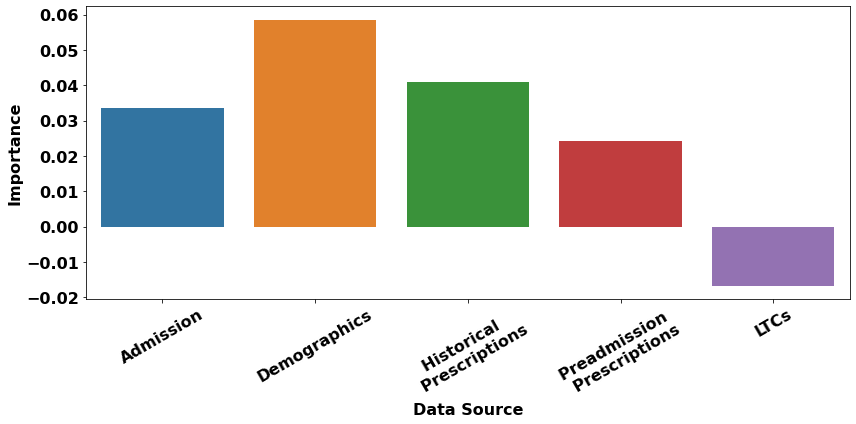

In [ ]:
import numpy as np                                                               
import matplotlib.pyplot as plt

lab=['Admission','Demographics','Historical \n Prescriptions','Preadmission \n Prescriptions','LTCs']

dfres = pd.DataFrame()
dfres['Data Source'] = lab
dfres['Importance'] = [np.round(i,4) for i in imp]

# fig, ax = plt.subplots(figsize=(12, 6))
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=dfres, x="Data Source", y="Importance")
ax.bar_label(ax.containers[0], size = 16)
plt.ylim(0,0.042)
plt.xticks(rotation=30,size = 16)
plt.yticks(size = 16)

plt.xlabel('Data Source',size = 16)
plt.ylabel('Importance',size = 16)
plt.tight_layout()
plt.savefig('figures/ablation.pdf', bbox_inches = 'tight')